##  <br>
![MLInit](https://drive.google.com/uc?id=1c1NajE2B_qMwKkQhOaxU1cal_c9zrYza)





## Init

In [ ]:
#@title Common Import and Configuration { display-mode: "form" }
!pip install catboost
!pip install fitter
!pip install 'lightgbm==3.0.0'

from fitter import Fitter, get_common_distributions, get_distributions
from ipywidgets import widgets
from IPython.display import display
from catboost import CatBoostRegressor
import catboost as cb
from math import sqrt
from os.path import exists

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from scipy.stats import kurtosis, skew

import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet, SGDRegressor, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import chi2
from numpy import mean
from numpy import std

from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import OrdinalEncoder

from google.colab import drive
from IPython.display import clear_output 
from google.colab import data_table

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
from ipywidgets import Label
from IPython.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor
import dateutil.parser
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import time
import random

drive.mount('/content/drive/')
dfpath = "/content/drive/Shareddrives/ICAIML_Project/ICAIML/Datasets"

In [194]:
#@title Load Data from Dataset Folder of ML Init
TTIVal = ["ML Init", "ML Init 2.0", "Nothing but ML Init"]
f = None

!ls "/content/drive/Shareddrives/ICAIML_Project/ICAIML/Datasets" >& Files.txt
drivefiles = open("Files.txt","r")
TTIVal = drivefiles.readlines()

#print(TTIVal)
uploaded = widgets.Dropdown(
    options=TTIVal,
    value=TTIVal[0],
    description='Select Dataset: ',
    disabled=False,
)

display(uploaded)

Dropdown(description='Select Dataset: ', options=('Airline_accidents.csv\n', 'corona.csv\n', 'FIFA_Players.csv…

In [80]:
#@title [OR] Upload A New Data Set
from google.colab import files
f = files.upload()

## Data Preparation

In [195]:
#@title Load Dataset and Select Target
selecteddf = dfpath +"/"+ uploaded.value[:-1]
df = None
if (f != None):
  df = pd.read_csv(list(f.keys())[0])
else:
  df = pd.read_csv(selecteddf)

#Remove Extra Column added
if 'Unnamed: 0' in df.columns:
  df = df.drop('Unnamed: 0', 1)

dfcols = df.columns
typs = df.dtypes
dfcols = list(dfcols)

dfbackup = df.copy()

target = ''
def on_button_clicked(b):
  global target
  target = tar.value
  print("Target Updated " + target)


tar = widgets.Dropdown(
    options=dfcols,
    value=dfcols[0],
    description='Select Target Value: ',
    disabled=False,
)

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [tar, okbutton]
box = widgets.Box(children=it)

okbutton.on_click(on_button_clicked)

display(box)

Box(children=(Dropdown(description='Select Target Value: ', options=('id', 'song_duration_ms', 'acousticness',…

Target Updated song_popularity


In [196]:
#@title Intelligent Feature Understanding & Transformation
display(HTML("<style>.blue_label { font-size: 20px; color: blue; font-weight: italic }</style>"))
display(HTML("<style>.green_label { font-size: 15px; color: green; font-weight: bold }</style>"))

common_datetime_names = ['date', 'time', 'day', 'year', 'hour', 'month', 'datetime', 'seasons']
transformed_datetime_names = ['Hour_sin', 'Hour_cos', 'Day_sin', 'Month_sin', 'Year_sin', 'Seasons_sin']
current_transformed_datetime_names = []

def transformDateTimeColumnData(df, existing_format_cols, type_=''):
  # ** Based on column name information
  for col in existing_format_cols:
    col_name = col + "_"
    if col.lower().find('hour') != -1 or type_ == 'hour':
      if df[col].max() > 12:
        hour_format = 24
      else:
        hour_format = 12

      #Transforming Hour as cyclic feature
      df[col_name + "_sin"] = np.sin(2 * np.pi * df[col]/hour_format)
      df[col_name + "_cos"] = np.cos(2 * np.pi * df[col]/hour_format)
      df = df.drop(col, axis=1)
      current_transformed_datetime_names.extend([col_name + "_sin", col_name + "_cos"])

    if col.lower().find('date') != -1 or type_ == 'date':
      try:
        df[col] = pd.to_datetime(df[col])
        max_days = df[col].dt.dayofweek.max()

        df[col_name + "_Month_sin"] = np.sin(2 * np.pi * df[col].dt.month/12.0)
        df[col_name + "_Day_sin"] =  np.sin(2 * np.pi * df[col].dt.dayofweek/max_days)
        current_transformed_datetime_names.extend([col_name + "_Month_sin", col_name + "_Day_sin"])
        df["Year"] = df[col].dt.year
        total_years = len(pd.unique(df["Year"]))
        if total_years < 3:
          df = df.drop("Year", axis=1)
        else:
          df = df.drop("Year", axis=1)
          df[col_name + "_Year_sin"] = np.sin(2 * np.pi * df[col].dt.year/total_years)
          current_transformed_datetime_names.append(col_name + "_Year_sin")
        df = df.drop(col, axis=1)
      except:
        #Invalid format
        continue

    if col.lower().find('season') != -1:
      unique_seasons = pd.unique(df[col])
      df[col].replace(unique_seasons, list(range(len(unique_seasons))), inplace=True)
      df[col_name + "_sin"] = np.sin(2 * np.pi * df[col]/len(unique_seasons))
      current_transformed_datetime_names.append(col_name + "_sin")
      df = df.drop([col], axis=1)

  return df


def transformCyclicData(df):
  current_transformed_datetime_names = []
  # 1. Check if any of the columns have already named as Date, Month, Day, Year etc.
  dfcols = list(df.columns)
  existing_format_cols = []
  for col_name in dfcols:
    if col_name.lower() in common_datetime_names:
      existing_format_cols.append(col_name)

  df = transformDateTimeColumnData(df, existing_format_cols)
  dfcols = list(df.columns)

  if len(existing_format_cols) > 0:
    printString = "We detected few time-series data, transformed following features as cyclic (sin, cos)  : " + str(existing_format_cols)
    l = Label(value=printString)
    l.add_class("blue_label")
    display(l)

  # 2. Based on content of the dataframe check if any data contains date time info
  existing_format_cols = []
  for col in dfcols:
    #Check other columns
    if col not in current_transformed_datetime_names:
      #Check for ~10 values
      invalid_counter = 0
      values = df[col].values[:10]
      for val in values:
        try:
          ans = dateutil.parser.parse(val)
        except:
          invalid_counter += 1
      
      if invalid_counter == 0:
        existing_format_cols.append(col)

  df = transformDateTimeColumnData(df, existing_format_cols, 'date')

  if len(existing_format_cols) > 0:
    printString = "Based on the content we detected time-series data, transformed following features as cyclic (sin, cos) :  " + str(existing_format_cols)
    l = Label(value=printString)
    l.add_class("green_label")
    display(l)

  return df

def transformFinancialDataColumns(df):

  def transform(input, symbol):
    if input == np.nan or input == float("nan"):
      return input

    try:
      input = re.sub(symbol, '', input)
      input = re.sub(',', '', input)

      multiplier = 1
      if input[-1] == 'K':
        multiplier = 1000
      elif input[-1] == 'M':
        multiplier = 1000000

      input = re.sub('K|M', '', input)
      input = float(input) * multiplier
      return input
    except:
      return input

  def transformDollar2Num(input):
    return transform(input, '\$')

  def transformEuro2Num(input):
    return transform(input, '\€')

  def transformPounds2Num(input):
    return transform(input, '\£')

  def transformRupees2Num(input):
    return transform(input, '\₹')

  currency2Method = {
      '$': transformDollar2Num,
      '£': transformPounds2Num,
      '€': transformEuro2Num,
      '₹': transformRupees2Num
  }

  def isHavingCurrencySymbol(input):
    regex = r"[\$|\£|\€|\₹]"
    try:
      match = re.search(regex, input)
    except:
      return -1

    if match != None:
      return match.group()
    return -1

  cols_having_curr_symbols = []
  #Find Currencies
  test_sample = 10
  dfcols = list(df.columns)
  for col in dfcols:
    if df.dtypes[col] == 'int64' or df.dtypes[col] == 'float64':
      continue

    values = df[col].values[:test_sample]
    for val in values:
      sym = isHavingCurrencySymbol(val)
      if sym == -1:
        break
      else:
        cols_having_curr_symbols.append([col, sym])
        break


  for col in cols_having_curr_symbols:
    df[col[0]] = df[col[0]].map(currency2Method[col[1]])

  if len(cols_having_curr_symbols) > 0:
    printString = "We detected some currency value marked as string ($100), transformed following features to its actual value : " + str(cols_having_curr_symbols)
    l = Label(value=printString)
    l.add_class("green_label")
    display(l)
  return df

######### Driver Code ############### 
df = transformCyclicData(df)
df = transformFinancialDataColumns(df)

In [197]:
#@title Feature Identification
catCols = []
numCols = []
tarCol = []
isRegression = True
typs = df.dtypes
#uniqRatio = []
for items in typs.iteritems():
    #print(items[0], items[1])
    if df[items[0]].count() == 0:
      continue
    #print(items[0], len(df[items[0]].unique()), len(df[items[0]].unique()) > 99)
    uRatio = len(df[items[0]].unique())/df[items[0]].count()

    if (items[1] == 'object' or items[1] == 'category' or items[1] == 'bool'):
      if (target == items[0]):
        isRegression = False
        tarCol.append(items[0])
      else:
        catCols.append(items[0])
    else:
      #uniqRatio.append((items, uRatio)
      isNum = (items[0] in current_transformed_datetime_names) or (df[items[0]].count() > 1000 and uRatio > 0.005) or (df[items[0]].count() < 1000 and uRatio > 0.1) or (len(df[items[0]].unique()) > 99) 

      if (isNum):
        if (target == items[0]):
          tarCol.append(items[0])
        else:
          numCols.append(items[0])
      else:
        if (target == items[0]):
          isRegression = False
          tarCol.append(items[0])
        else:
          catCols.append(items[0])
probtype = ""
if isRegression:
  probtype = "Regression Problem"
else:
  probtype = "Classification Problem"

featureDF = pd.DataFrame()
featureDF["Features"] = numCols + catCols
numdesc = ["Numerical"]*len(numCols)
catdesc = ["Categorical"]*len(catCols)
featureDF["Type"] = numdesc + catdesc
    
display(HTML("<style>.blue_label { font-size: 20px; color: blue; font-weight: italic }</style>"))
display(HTML("<style>.green_label { font-size: 15px; color: green; font-weight: bold }</style>"))

l = Label(value=probtype)
l.add_class("blue_label")
display(l)

l2 = Label(value="Target :"+target)
l2.add_class("green_label")
display(l2)

data_table.DataTable(featureDF, include_index=False, num_rows_per_page=20,min_width="100")

Label(value='Classification Problem', _dom_classes=('blue_label',))

Label(value='Target :song_popularity', _dom_classes=('green_label',))

,Features,Type
0,id,Numerical
1,song_duration_ms,Numerical
2,acousticness,Numerical
3,danceability,Numerical
4,energy,Numerical
5,instrumentalness,Numerical
6,liveness,Numerical
7,loudness,Numerical
8,speechiness,Numerical
9,tempo,Numerical


In [198]:
#@title Remove unwanted features 
#@markdown In case a feature is wrongly removed, try reloading from 'Select Target'
def on_button_clicked2(b):
  global df
  global checkboxes
  global dfcols
  global catCols
  global numCols
  selected_data = []
  for i in range(0, len(checkboxes)-1):
      if checkboxes[i].value == True:
          selected_data = selected_data + [checkboxes[i].description]
  if target in selected_data:
      print("You cannot remove TARGET. Please unselect to continue")
      return
  df = df.drop(axis=0, columns=selected_data)
  
  catCols = list(set(catCols) - set(selected_data))
  numCols = list(set(numCols) - set(selected_data))
  dfcols = df.columns

  if (len(selected_data) > 0):
    display(HTML("<style>.blue_label { font-size: 20px; color: blue; font-weight: italic }</style>"))
    display(HTML("<style>.green_label { font-size: 15px; color: green; font-weight: bold }</style>"))

    l = Label(value="Featured Removed")
    l.add_class("blue_label")
    display(l)

    l2 = Label(value=str(selected_data))
    l2.add_class("green_label")
    display(l2)


okbutton1 = widgets.Button(
    description='OK',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check' 
)

dfcols = list(df.columns)
okbutton1.on_click(on_button_clicked2)

checkboxes = [widgets.Checkbox(value=False, description=label) for label in dfcols]
checkboxes.append(okbutton1)
output = widgets.VBox(children=checkboxes)
display(output)

Label(value='Featured Removed', _dom_classes=('blue_label',))

Label(value="['id']", _dom_classes=('green_label',))

In [199]:
#@title Encode Categorical columns  { display-mode: "form" }
ord_enc = OrdinalEncoder()

for col in catCols:
  #convert the datatype uniformly in case of mismatched datatype
  df[col] = [str(int(x)) if isinstance(x, int) else x for x in df[col]]
  df[col] = df[col].astype('category')
  df[col] = ord_enc.fit_transform(df[[col]])

if isRegression != True:
  df[target] =  df[target].astype('category')
  df[target] = ord_enc.fit_transform(df[[target]])

## Imputation
Choose the imputation technique for each feature

In [200]:
#@title Imputation
df_m = df.copy()
missing_cols = df.columns[df.isnull().any()]
if not missing_cols.any():
  print("All values are present")
#print(missing_cols)
cat_imp = ["KNN imputer","Most Frequent","Drop"]
Numerical_imp = ["KNN imputer","Iterative imputer","Mean","Median","Window","Drop"]
i=0
num = len(missing_cols)
#for x in missing_cols:
def func(k):
  global df
  x = missing_cols[k]
  done = True
  def on_button_clickedimp(b):
    global df_m, df
    global i
    imp = radiobutton1.value
    print("Imputed '" + x + "' with Strategy: " + imp)
    if(x in catCols):
      if(imp==cat_imp[0]):
        temp1 = KNNImputer(n_neighbors=2)
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      elif(imp==cat_imp[1]):
        temp1 = SimpleImputer(strategy='most_frequent')
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      else:
        df_m = df_m[df_m[x].notna()]
    else:
      if(imp==Numerical_imp[0]):
        temp1 = KNNImputer(n_neighbors=2)
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      elif(imp==Numerical_imp[1]):
        temp1 = IterativeImputer(random_state=42)
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      elif(imp==Numerical_imp[2]):  
        temp1 = SimpleImputer(strategy='mean')
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      elif(imp==Numerical_imp[3]):  
        temp1 = SimpleImputer(strategy='median')
        df_m[x] = temp1.fit_transform(df_m[[x]]).ravel()
      elif(imp==Numerical_imp[4]):
        df_m[x] = df_m[x].fillna(method="bfill").fillna(method="ffill")
        #call bfiil fill  
      else:
        df_m = df_m[df_m[x].notna()]
        #drop_Values
    if(i<num-1):
      i+=1
      clear_output()
      func(i)
    else:
      clear_output()
      print("Imputation Done")
      df = df_m
  if(x in catCols):
    imp_cols = cat_imp
  else:
    imp_cols = Numerical_imp

  desc = ", Select Method of Imputation"
  l = Label(value=x)
  display(HTML("<style>.green_label { font-size: 15px; color: green; font-weight: bold }</style>"))
  l.add_class("green_label")
  okbuttonimp = widgets.Button(
      description='OK',
      disabled=False,
      button_style='',
      tooltip='Click me',
      icon='check' 
    )
  radiobutton1 = widgets.RadioButtons(description=desc,disabled=False,options=imp_cols,style= {'description_width': 'initial'}) 
  it = [l, radiobutton1, okbuttonimp]
  box = widgets.Box(children=it)
  
  okbuttonimp.on_click(on_button_clickedimp)

  display(box)

if not missing_cols.any():
  print("All values are present")
else:
  func(i)

Imputation Done


## EDA: Plots and Analysis

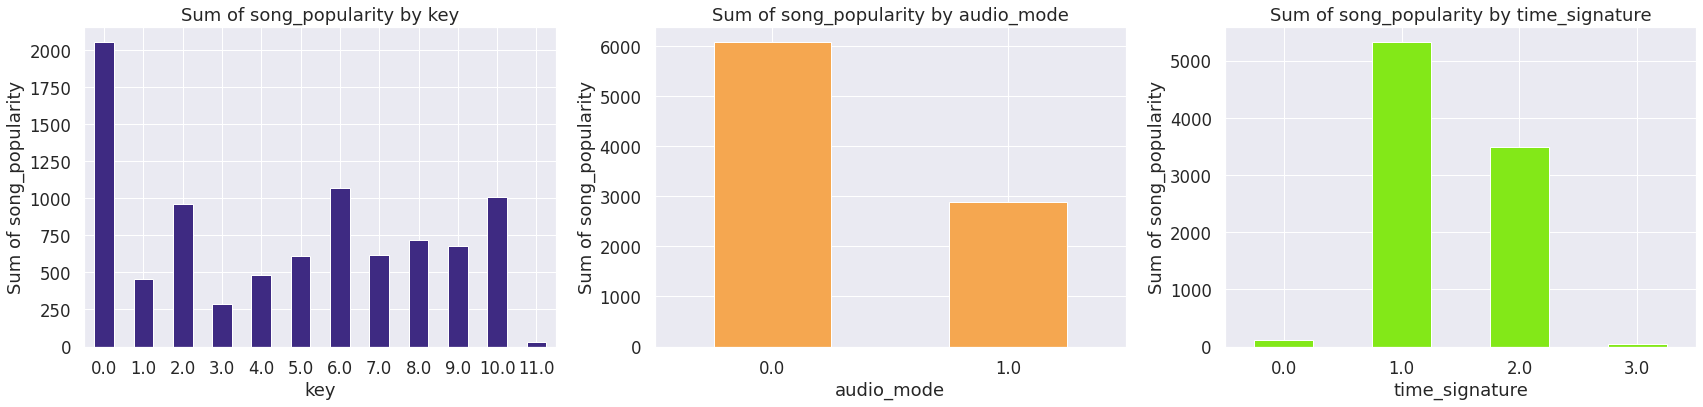

In [209]:
#@title Run and Select EDA Plot to Display { display-mode: "form" }
cols = ["Histogram", "Correlation Heatmap", "Correlation Bargraph", "Correlation with Target", "Count Plot(Categorical)", 
        "Box Plot (Numerical)", "Violin Plot", "QQ Plot",
        "Mutual Information", "Distribution vs. Target(categorical)",
        "Chi Square Test"]

def Chi2(df, numCols):
  df = df.drop(numCols, axis=1)
  
  if (len(df.columns) > 30):
    print("Too many columns. Skipping")
    return
  resultant = pd.DataFrame(data=[(0 for i in range(len(df.columns))) for i in range(len(df.columns))], 
                          columns=list(df.columns))
  resultant.set_index(pd.Index(list(df.columns)), inplace = True)

  # Finding p_value for all columns and putting them in the resultant matrix
  for i in list(df.columns):
      for j in list(df.columns):
          if i != j:
              chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
              resultant.loc[i,j] = p_val

  fig = plt.figure(figsize=(12,8))
  sns.heatmap(resultant, cmap='Blues', annot=True)
  plt.title('Chi-Square Test Results')
  plt.tight_layout()
  plt.savefig('chi2.png', dpi=300, bbox_inches='tight')

def CorrelationHM(df):
  if (len(df.columns) > 30):
    print("Too many features. Skipping Correlation Analysis!")
    return
  plt.figure(figsize=(12, 8))
  ###########NOTE: Here, the logic should be based on the value chose 
  if (len(df.columns) < 20):
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="YlGnBu", annot=True)
  else:
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="YlGnBu")

  heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
  plt.tight_layout()
  plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
 
def Histogram(df):

  df.hist(bins=25,figsize=(20,15))
  plt.tight_layout()
  plt.savefig('Histogram.png', dpi=300, bbox_inches='tight')

def Countplot(df, catCols):
  if (len(catCols) == 0):
    return
  #Some cleaning for avoiding cat cols with too many categories.
  badCols = []
  for f in catCols:
      if (len(df[f].unique()) >= 100):
          badCols.append(f)
  
  catCols = list (set(catCols) - set(badCols))

  height = int(len(catCols)/3) if len(catCols)%3 == 0 else (int(len(catCols)/3) + 1)
  width = 3 if len(catCols) >= 3 else len(catCols)
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  index = 0
  for f,ax in zip(catCols, axes.ravel()):
      if (len(df[f].unique()) < 100):
          sns.countplot(df[f], ax=ax)
          plt.setp(ax.get_xticklabels(), rotation=45, fontsize=7)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Countplot.png', dpi=300, bbox_inches='tight')


def Boxplot(df, catCols):
  if (len(catCols) == 0):
    return
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else int(len(catCols)/3) + 1
  width = 3 if len(catCols) >= 3 else len(catCols)+1
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  for f,ax in zip(catCols, axes.ravel()):
      sns.boxplot(df[f], ax=ax)
      plt.setp(ax.get_xticklabels(), rotation=45)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Boxplot.png', dpi=300, bbox_inches='tight')

def Violinplot(df, catCols, target):
  if (len(catCols) == 0):
    return
  global isRegression
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else int(len(catCols)/3) + 1
  width = 3 if len(catCols) >= 3 else len(catCols)+1
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  for f,ax in zip(catCols, axes.ravel()):
      if isRegression:
        sns.violinplot(x=df[f], ax=ax)
      else:
        sns.violinplot(x=df[target], y=df[f], ax=ax)
      #plt.setp(ax.get_xticklabels(), rotation=45)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Violinplot.png', dpi=300, bbox_inches='tight')

def QQPlot(df, dfcols, target):
  if (len(dfcols) == 0):
    return
  
  fig, axs = plt.subplots(len(dfcols), 2,
                        figsize=(10, len(df.columns)*6))
  fig.tight_layout()
  for i, col in enumerate(dfcols):
      sns.histplot(df[col], ax=axs[i, 0])
      sm.qqplot(df[col].dropna(), line="s", ax=axs[i, 1], fmt='b')
      axs[i, 1].set_title(col)

def Correlation_Target_Heatmap(df, target):
  df2 = df.copy() 
  plt.figure(figsize=(12, 8))
  heatmap = sns.heatmap(df2.corr()[[target]].sort_values(by=target, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
  title = 'Features Correlating with ' + target 
  heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);
  
  plt.tight_layout()
  plt.savefig('heatmapTarget.png', dpi=300, bbox_inches='tight')

def Correlation_Target(df, target):
  df2 = df.copy() 
  df2 = df2.fillna(method="bfill").fillna(method="ffill")
  df_features = df2.drop(target, axis=1) # drop labels for training set
  df_labels = df2[target].copy()
  
  plt.figure(figsize=(10, 5))
  featurelist= df_features.columns
  features = np.array(featurelist)

  visualizer = FeatureCorrelation(labels=features, color='Orange', sort=True)
  visualizer.fit(df_features, df_labels)
  plt.savefig('Pearson_correlation.png', dpi=300, bbox_inches='tight')
  plt.tight_layout()
  visualizer.show()

def Mutual_Information(df, target):
  df2 = df.copy()
  df2 = df2.fillna(method="bfill").fillna(method="ffill")
  df_features = df2.drop(target, axis=1) # drop labels for training set
  df_labels = df2[target].copy()
 
  plt.figure(figsize=(10, 5))
  featurelist= df_features.columns
  features = np.array(featurelist)

  visualizer = FeatureCorrelation(labels=features, color='Green',method='mutual_info-classification', sort=True)
  visualizer.fit(df_features, df_labels, random_state=42)
  plt.savefig('Mutual_Information.png', dpi=300, bbox_inches='tight')
  plt.tight_layout()
  visualizer.show()


def Barplot_categorical(df, catCols, target):
  if (len(catCols) == 0):
    print("No categorical feature available!")
    return
  global isRegression
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else int(len(catCols)/3) + 1
  width = 3 if len(catCols) >= 3 else len(catCols)+1
  figure, axes = plt.subplots(height, width, figsize=(width*8, height*6))

  for f,ax in zip(catCols, axes.ravel()):
      r = random.random()
      b = random.random()
      g = random.random()
      color = (r, g, b)
      if isRegression:
        groupDF = df.groupby([f])[target].agg(['mean'])
        groupDF.plot.bar(subplots=True, ax=ax, color=color, label='mean')
        str = "Average" + " " + target + " by " + f
        ax.set_title(str)
        ax.set_ylabel("Average" + " " + target)
        legend = 'mean'
      else:
        groupDF = df.groupby([f])[target].sum(['sum'])
        groupDF.plot.bar(subplots=True, ax=ax, color=color)
        str = "Sum of" + " " + target + " by " + f
        ax.set_title(str)
        ax.set_ylabel("Sum of" + " " + target)
        legend = 'Sum'
      plt.setp(ax.get_xticklabels(), rotation=0)
    
  #plt.xticks(ax.get_xticklabels(), how to get text of labels?)
  figure.tight_layout()
  plt.savefig('BarPlots.png', dpi=300, bbox_inches='tight')
  plt.show()


def on_button_clicked(b):
  clear_output()
  selected = edas.value
  if (selected == cols[0]):
    Histogram(df)
  elif (selected == cols[1]):
    CorrelationHM(df)
  elif (selected == cols[2]):
    Correlation_Target(df, target)
  elif (selected == cols[3]):
    Correlation_Target_Heatmap(df, target)
  elif (selected == cols[4]): #Passing backup Dataframe for printing un-encoded values
    Countplot(dfbackup, catCols)
  elif (selected == cols[5]):
    Boxplot(df, numCols)
  elif (selected == cols[6]):
    Violinplot(df, dfcols, target)
  elif (selected == cols[7]):
    QQPlot(df, dfcols, target)
  elif (selected == cols[8]):
    Mutual_Information(df, target)
  elif (selected == cols[9]):
    Barplot_categorical(df, catCols, target)
  elif (selected == cols[10]):
    if (len(catCols) > 1):
      Chi2(df, numCols)
    else:
      print("Not enough categorical features!")

edas = widgets.Dropdown(
    options=cols,
    value=cols[0],
    description='Select EDA: ',
    disabled=False,
)

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [edas, okbutton]
box = widgets.Box(children=it)

okbutton.on_click(on_button_clicked)

display(box)


In [214]:
#@title Analysis and Inferences from EDA { display-mode: "form" }
def vif_scores(df, numCols):
    df1 = df[numCols] #other way?
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Numerical Features"] = df1.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df1.values,i) for i in range(df1.shape[1])]
    VIF_Scores.sort_values("VIF Scores", axis = 0, ascending = False, inplace=True)
    return VIF_Scores

#Variance Inflation Factor
def MLInit_VIF(df, numCols):
  str = "This dataset has no High multi-collinearity"
  if (len(numCols) > 1):
    mydf = vif_scores(df, numCols)
    index = mydf[mydf['VIF Scores'] <= 10].index
    newdf = mydf.drop(index)
    if (newdf.empty != True):
      val = newdf["Numerical Features"]
      str = "Highly Multicollinear features are "
      text = []
      for i in val.index:
        text.append(val[i])
      for i in range(0, len(text)-1):
        str = str + text[i] + ", "
      str = str + text[len(text)-1]+ "."

  display(HTML("<style>.red_label { font-size: 20px; color: red; font-weight: bold }</style>"))
  l = Label(value=str)
  l.add_class("red_label")
  display(l)
  if (len(numCols) > 1):
    display(mydf)

def MLInit_PCA(df):
  sc = StandardScaler()
  data_scaled = sc.fit_transform(df)
  pca = PCA(n_components=None)
  pca.fit(data_scaled)

  # Get the eigenvalues
  #print("Eigenvalues:")
  #print(pca.explained_variance_)
  #print()

  # Get explained variances
  #print("Variances (Percentage):")
  #print(pca.explained_variance_ratio_ * 100)
  store_var = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(store_var)

  plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
  plt.xlabel("Number of components (Dimensions)")
  plt.ylabel("Explained variance (%)")
  plt.show()

  display(HTML("<style>.red_label { font-size: 15px; color: Magenta; font-weight: Bold }</style>"))
  l = Label(value="Select the amount of variance you wish to retain?")
  l.add_class("red_label")
  display(l)

  int_range = widgets.IntSlider(description="Variance: ", continuous_update=False, step=5)
  output2 = widgets.Output()
  display(int_range, output2)
  def on_value_change(change):
    with output2:
        var = change['new']
        for i in range(0, len(store_var)):
          if (store_var[i] >= var):
            n_components = i+1
            break
        print("Suggested to choose number of components = ", n_components)

  int_range.observe(on_value_change, names='value')


acols = ["Skewness Detection",
         "Multi-Collinearity Test", 
         "Dimensionality Reduction Test", 
        "Missing Datapoints Report"]

def MissingDataAnalysis(df):
  df2 = df.copy()
  dfcols = list(df2.columns)
  missingCols = df2.isna().sum()
  totalCount = df2.shape[0]

  missingRepDF = pd.DataFrame()
  missingRepDF["Features"] = dfcols
  missingRepDF["Missing Values"] = [df2[col].isna().sum() for col in dfcols]
  missingRepDF["Missing Values Ratio"] = missingRepDF["Missing Values"]/totalCount

  missingRepDF.drop(missingRepDF[missingRepDF['Missing Values'] == 0].index, inplace=True)

  display(missingRepDF)
  return list(missingRepDF["Features"])


def SkewnessDetection(df, numCols):
  #https://www.statology.org/skewness-kurtosis-python/
  string = "Features are not Skewed"
  col_skew = dict()
  col_skew_kurt = dict()
  col_remark = dict()

  for col in numCols:
    col_skew[col] = skew(df[col])
    col_skew_kurt[col] = kurtosis(df[col], fisher = False)
    remark = ""
    if (col_skew[col] < -1.0):
      remark += "Highly skewed (Negative)"
    elif (col_skew[col] > 1.0):
      remark += "Highly skewed (Positive)"
    elif (col_skew[col] > 0.5):
      remark += "Skewed (Positive)"
    elif (col_skew[col] < -0.5):
      remark += "Skewed (Negative)"
    else:
      remark += "Approximately Symmetric"
    


    if (col_skew_kurt[col] < -1.0):
      remark += ", Distribution is too flat"
    elif (col_skew[col] > 1.0):
      remark += ", Distribution is too peaked"
    
    col_remark[col] = remark

  col_skew = dict(sorted(col_skew.items(), key=lambda item: item[1]))
  features = list(col_skew.keys())
  SkewValue = list(col_skew.values())

  #col_skew_kurt = dict(sorted(col_skew_kurt.items(), key=lambda item: item[1]))
  features_kurt = list(col_skew_kurt.keys())
  SkewValue_kurt = list(col_skew_kurt.values())

  features_rem = list(col_remark.keys())
  remark = list(col_remark.values())


  if len(features) >= 1:

    skewedDF = pd.DataFrame()
    skewedDF["Features"] = features
    skewedDF["Skewness"] = SkewValue
    remarkDF = pd.DataFrame()
    remarkDF["Features"] = features_rem
    remarkDF["Interpretation"] = remark

  if len(features_kurt) >= 1:
    
    skewedDFK = pd.DataFrame()
    skewedDFK["Features"] = features_kurt
    skewedDFK["Kurtosis"] = SkewValue_kurt

  combinedDF1 = pd.merge(skewedDF, skewedDFK, on='Features')
  combinedDF = pd.merge(combinedDF1, remarkDF, on='Features')
  #combinedDF.drop(combinedDF[(combinedDF['Skewness'] > -0.5) & (combinedDF['Skewness'] < 0.5) ].index, inplace=True)
  #combinedDF1 = combinedDF1[combinedDF1['Skewness'] > -0.5]
  #combinedDF.drop(combinedDF1, inplace=True)
  display(combinedDF)
  return combinedDF

def on_button_clicked3(b):
  selected = analysis.value
  clear_output()
  if (selected == acols[0]):
    SkewnessDetection(df, numCols)
  elif (selected == acols[1]):
    MLInit_VIF(df, numCols)
  elif (selected == acols[2]):
    MLInit_PCA(df)
  elif (selected == acols[3]):
    MissingDataAnalysis(dfbackup)

analysis = widgets.Dropdown(
    options=acols,
    value=acols[0],
    description='Select Analysis: ',
    disabled=False,
)

okbutton3 = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [analysis, okbutton3]
box2 = widgets.Box(children=it)

okbutton3.on_click(on_button_clicked3)

display(box2)

Box(children=(Dropdown(description='Select Analysis: ', options=('Skewness Detection', 'Multi-Collinearity Tes…

song_duration_ms


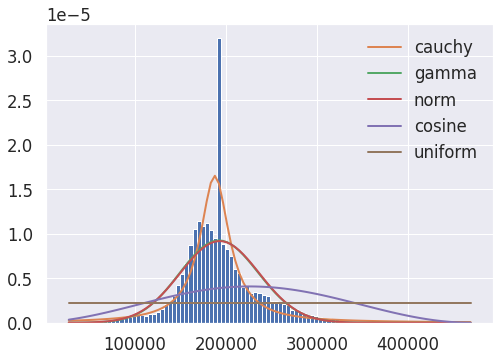

In [215]:
#@title Select Feature and Find its approximate Distribution
def getDistribution(col):
  col_data = df[col].values
  dist = get_common_distributions()
  dist.append('cosine')
  f = Fitter(col_data, distributions= dist)
  f.fit()
  f.summary()

def on_button_clicked(b):
  clear_output()
  selected = featureDistributions.value
  print(selected)
  getDistribution(selected)

featureDistributions = widgets.Dropdown(
    options=numCols,
    value=numCols[0],
    description='Select Feature: ',
    disabled=False,
)

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [featureDistributions, okbutton]
box = widgets.Box(children=it)

okbutton.on_click(on_button_clicked)

display(box)

## Modelling (Advanced Features)

rand error sum 8.59236520286845 strat_error_sum -0.39529260524940923


,Overall,Stratified,Random,Rand. %error,Strat. %error
0.0,0.232023,0.232033,0.232596,0.247088,0.004412
1.0,0.053522,0.053542,0.053645,0.229533,0.038256
2.0,0.102293,0.102273,0.101505,-0.770616,-0.020016
3.0,0.033702,0.033681,0.034142,1.306197,-0.060753
4.0,0.054423,0.054412,0.053952,-0.865312,-0.018811
5.0,0.073874,0.073864,0.072891,-1.330377,-0.013858
6.0,0.125348,0.125358,0.126280,0.743221,0.008167
7.0,0.065971,0.065981,0.065930,-0.062073,0.015518
8.0,0.075799,0.075809,0.076986,1.566721,0.013506
9.0,0.073014,0.072993,0.072942,-0.098149,-0.028043


Histogram of  key


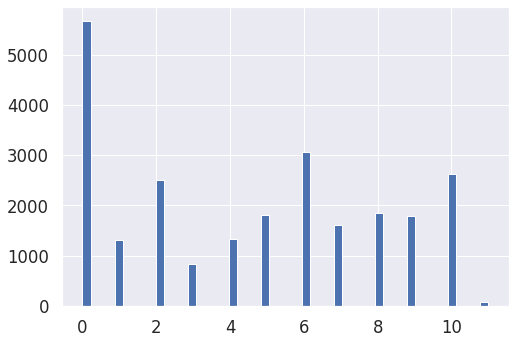

In [225]:
#@title Stratification based on top correlated features { display-mode: "form" }
#code to get top correlated features
corr = df.corr()[target]
#corr = corr.drop(target)
relevant_features = corr[corr>0]
first_column = relevant_features.index
first_column.append(df[target].index)
if (len(first_column) < 5):
  con = len(first_column)
else:
  con = 5

def cat_proportions(mydata, str):
  return mydata[str].value_counts() / len(mydata)

def strat_func(df, sel_col, mytarget, slider):
  split = slider.value
  if (split == 0):
    split = 20
  if (sel_col in catCols):
    is_continuous = False
  else:
    is_continuous = True
  strat_df = df.copy()
  if (is_continuous):
    min = 0
    max = 0
    bucket = 0
    min = strat_df[sel_col].min()
    max = strat_df[sel_col].max()
    bucket = (max-min)/5 #get bucket size from user, #remove cat cols
    bins=[]
    val = min-1.0 #we need to give value lesser than min else we may get Nan
    bins.append(val)
    for i in range(0, 4):
      val = val + bucket
      bins.append(val)
    bins.append(np.inf)
    str = sel_col + "_cat"
    strat_df[str] = pd.cut(strat_df[sel_col], bins=bins, labels=[1,2,3,4,5])
    df_train_strat, df_test_strat = train_test_split(strat_df, test_size=(split/100), random_state=42, stratify=strat_df[str])
  else:
    df_train_strat, df_test_strat = train_test_split(strat_df, test_size=(split/100), random_state=42, stratify=strat_df[sel_col])
    str = sel_col
  df_train, df_test = train_test_split(strat_df,test_size=(split/100),random_state=42)
  compare_props_train = pd.DataFrame({
      "Overall": cat_proportions(strat_df, str),
      "Stratified": cat_proportions(df_train_strat, str),
      "Random": cat_proportions(df_train, str),
  }).sort_index()
  compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
  compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100
  rand_error_sum = compare_props_train["Rand. %error"].sum()
  strat_error_sum = compare_props_train["Strat. %error"].sum()
  print("rand error sum", rand_error_sum, "strat_error_sum", strat_error_sum)
  display(compare_props_train)
  print("Histogram of ", sel_col)
  df[sel_col].hist(bins=50)
  #remove add cat column
  if (is_continuous):
    df_train_strat.drop(str, axis=1, inplace=True)
    df_test_strat.drop(str, axis=1, inplace=True)
  return df_train_strat, df_test_strat

display(HTML("<style>.red_label { font-size: 15px; color: Magenta; font-weight: Bold }</style>"))
l = Label(value="Select the test data split percentage")
l.add_class("red_label")
display(l)

int_range = widgets.IntSlider(description="Percentage: ", continuous_update=False, min=10, max=50, step=5, value=20)
output2 = widgets.Output()
display(int_range, output2)
def on_value_change(change):
  with output2:
    var = change['new']
    print("Test data Split percentage selected: ", var,"%")
int_range.observe(on_value_change, names='value')

def on_button_clicked(b):
  global train, test
  clear_output()
  selected = strat.value
  train, test = strat_func(df, selected, target, int_range)

strat = widgets.Dropdown(
    options=first_column,
    value=first_column[0],
    description='Select: ',
    disabled=False,
)

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

display(HTML("<style>.green_label { font-size: 17px; color: Green; font-weight: Bold }</style>"))
l2 = Label(value="Select the feature to stratify")
l2.add_class("green_label")

it = [l2, strat, okbutton]
box = widgets.Box(children=it)
okbutton.on_click(on_button_clicked)
display(box)

In [226]:
#@title Prepare data by scaling and encoding { display-mode: "form" }
def prepare_data(train, test, categorical_col, numerical_col):
  """ Preprocessing the data"""
  X_train = np.array([]); y_train = np.array([]); X_test = np.array([]); y_test = np.array([]);

  X = train.drop([target], axis=1)
  y_train = train[target]

  # Do not touch test data
  X_t = test.drop([target], axis=1)
  y_test = test[target]

  cat_pipeline = Pipeline([
                         ('encoder',OneHotEncoder())
                         ])

  num_pipeline = Pipeline([
                         ('scaler',StandardScaler())
                         ])
  
  full_pipeline = ColumnTransformer([
                                    ('num', num_pipeline, numerical_col),
                                    ('cat', cat_pipeline, categorical_col),
                                    ])
  
  X_train = full_pipeline.fit_transform(X)
  X_test = full_pipeline.transform(X_t)
  ###############################
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_data(train, test, catCols, numCols)
print("Train data", X_train.shape, y_train.shape)
print("Test data", X_test.shape, y_test.shape)

Train data (19536, 28) (19536,)
Test data (4884, 28) (4884,)


In [227]:
#@title Metric function { display-mode: "form" }
def getAccuracy(y_test, y_pred):
  global isRegression
  clear_output()

  display(HTML("<style>.green_label { font-size: 15px; color: green; font-weight: bold }</style>"))
  if isRegression:
    RMSE = mean_squared_error(y_pred, y_test, squared=False)
    R2 = r2_score(y_pred, y_test, multioutput='variance_weighted')
    printString = "Model : "+type(selectedModel).__name__+",  RMSE = " +str(RMSE)+ ", R2 ="+ str(R2)
    l = Label(value=printString)
    l.add_class("green_label")
    display(l)
  else:
    acc_score = accuracy_score(y_test, y_pred)
    printString = "Accuracy score--> " + str(acc_score)
    l = Label(value=printString)
    l.add_class("green_label")
    display(l)
    report = classification_report(y_test, y_pred)
    printString = "\nClassification report: \n" + report
    print(printString)
    
    try:
      cm = confusion_matrix(y_test, y_pred)
      conf_matrix_show(cm)
      tp, fn, fp, tn = cm.reshape(-1)

      fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
      printString = "AUC --> " +  str(metrics.auc(fpr, tpr))
      l = Label(value=printString)
      l.add_class("green_label")
      display(l)
    except:
      pass

# Function to create a confusion matrix 
def conf_matrix_show(con_mat):    
    # Creating a confusion matrix
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

Label(value='Accuracy score--> 0.6281736281736282', _dom_classes=('green_label',))


Classification report: 
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77      3073
         1.0       0.00      0.00      0.00      1811

    accuracy                           0.63      4884
   macro avg       0.31      0.50      0.39      4884
weighted avg       0.40      0.63      0.49      4884



Label(value='AUC --> 0.4991864627399935', _dom_classes=('green_label',))

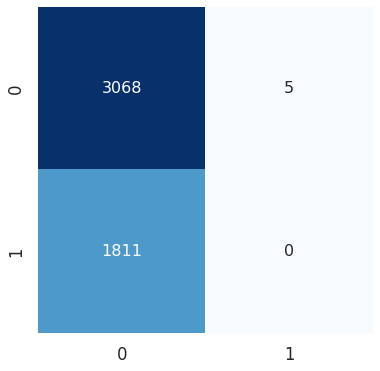

In [232]:
#@title Model Recommendation & Evaluation { display-mode: "form" }


def gridsearch_run(model, param_grid, scoring='f1', nsplits=5):
  clear_output()
  print('Training Started...')
  model.fit(X_train, y_train)
  print('Completed')
  y_pred = model.predict(X_test)
  getAccuracy(y_test, y_pred)

modelObjects = {"LinearRegression": LinearRegression, "RidgeCV" : RidgeCV, "Lasso": Lasso, "ElasticNet":ElasticNet,
                "SGDRegressor" : SGDRegressor, "CatBoostRegressor":CatBoostRegressor, 'LGBMRegressor':LGBMRegressor, 'XGBRegressor':XGBRegressor,
                
                'LogisticRegression':LogisticRegression, 'SVC':SVC, 'SGDClassifier': SGDClassifier, 'KNeighborsClassifier':KNeighborsClassifier,
                'DecisionTreeClassifier' : DecisionTreeClassifier, 'RandomForestClassifier':RandomForestClassifier, 
                'GradientBoostingClassifier' : GradientBoostingClassifier
                }

selectedModel = None

def getModel(model):
  global selectedModel
  selectedModel = modelObjects[model]()
  return selectedModel

def showHyperParams(estimator):
  string = estimator + " -> "+ str(getModel(estimator).get_params())
  display(HTML("<style>.red_label { font-size: 15px; color: Blue; font-weight: Bold }</style>"))
  l = Label(value=string)
  l.add_class("red_label")
  display(l)

def RunCV(b):
  clear_output()
  val = "global param_grid;" + wid.value
  #get param_grid
  exec(val)
  if isRegression:
    gridsearch_run(selectedModel, param_grid, scoring="r2")
  else:
    gridsearch_run(selectedModel, param_grid, scoring="f1")

def ShowEditBox():
  global wid, out

  clear_output()
  it  = []
  default_params = str(selectedModel.get_params())

  wid = widgets.Textarea(
      value='param_grid = '+ default_params,
      placeholder='params',
      description='Model Hyper-params : ',
      disabled=False,
      style= {'description_width': 'initial'},
      layout={'height': '100%', 'width': '100%', })

  okbutton = widgets.Button(
    description='Fit & Evaluate',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
  )

  okbutton.on_click(RunCV)
  it = [wid, okbutton]
  box = widgets.VBox(children=it, layout={'height': '200px', 'width': '1000px'})
  display(box)

def getRecommendedModel():
  return -1

#https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods
if isRegression:
  models = ['LinearRegression', "RidgeCV", "Lasso", "ElasticNet", 'SGDRegressor', 'CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor']
else:
  models = ['LogisticRegression', 'SVC', 'SGDClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

model_suggestion = getRecommendedModel()

out = widgets.Output(layout={'border': '1px solid black'})
modelSelection = widgets.Dropdown(
    options=models,
    value=models[model_suggestion],
    description='Select The Model to Train : ',
    disabled=False,
    style= {'description_width': 'initial'}
)

def on_button_clicked(b):
  clear_output()
  selected = modelSelection.value
  showHyperParams(selected)
  ShowEditBox()

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [modelSelection, okbutton]
box = widgets.Box(children=it)
okbutton.on_click(on_button_clicked)
display(box, out)